<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/keras_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model

In [8]:
def plot_image(img):
  plt.imshow(img.reshape((28, 28)), cmap='gray', interpolation='none')
  cbar = plt.colorbar()
  cbar.set_label('Pixel Intensity')
  plt.show()

In [9]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding="valid", activation="relu"),
        layers.Conv2D(  128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=None),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        4160      
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 128)         295040    
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 128)         409728    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 10)               

In [11]:
batch_size = 500
epochs = 8

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
opt = keras.optimizers.Adam(learning_rate=0.001)

In [12]:
# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
# model.save('deepKNN_model.h5')  # creates a HDF5 file 
keras.backend.set_learning_phase(False)
# returns a compiled model
model = load_model('deepKNN_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02789144217967987
Test accuracy: 0.9911999702453613


In [14]:
for layer in model.layers:
  print(layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 128), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dens

In [15]:
def reshaped_layer(model, x):
    #function to get the layer wise output representation of the model for data x
    layer_output = []
    for i in [0,1,2,5]:
        layer = model.layers[i]
        print(layer)
        l_op = K.function([model.layers[0].input],
                                      [layer.output])([x])[0]
        layer_output.append(l_op)

    reshaped_output_layer = []
    
    for output in layer_output[0:3]:
        reshaped_output_layer.append(output.reshape(output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        
    reshaped_output_layer.append(layer_output[3])
    
    for layer in reshaped_output_layer:
        assert layer.dtype == np.float32
        #print('Normalizing the dataset')
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)
        #print('Done')        
    return(reshaped_output_layer)

activations = reshaped_layer(model, x_test)

In [65]:
# import the necessary packages
from tensorflow.keras.losses import MSE
import tensorflow as tf
def generate_image_adversary(model, image, label, eps):
  # cast the image
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)
  # record our gradients
  with tf.GradientTape() as tape:
    # explicitly indicate that our image should be tacked for
    # gradient updates
    tape.watch(image)
    # use our model to make predictions on the input image and
    # then compute the loss
    pred = model(image)
    loss = MSE(label, pred)

    # calculate the gradients of loss with respect to the image, then
    # compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    # construct the image adversary
    adversary = (image + (signedGrad * eps)).numpy()
    # return the image adversary to the calling function
    return adversary

In [66]:
# loop over a sample of our testing images
# grab the current image and label
image = x_test[0]
label = y_test[0]
# generate an image adversary for the current image and make
# a prediction on the adversary
adversary = generate_image_adversary(model, image, label, eps=0.15)
pred = model.predict(adversary)
np.argmax(pred, axis=1) 

(28, 28, 1)


array([3])

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

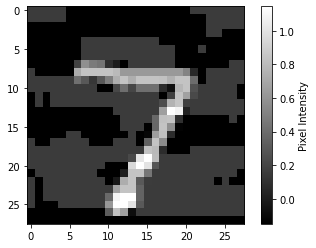

In [67]:
plot_image(adversary)